# Building a Handwritten Digits Classifier

In this project, we'll be using a neural network to try and predict which digit is being represented by the image we are reading. The images we'll be using are from the sci-kit learn python library. The images are 8 x 8 arrays of pixels with varying levels of intensity. We'll begin by loading in the dataset and visualizing one of the images so we have an idea of what these digits might look like.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
data = load_digits()

In [2]:
labels = pd.Series(data['target'])
data_sub = pd.DataFrame(data['data'])

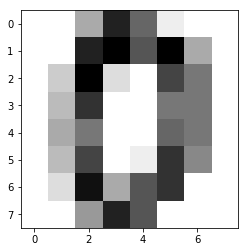

In [3]:
first_image = data['images'][0]
plt.imshow(first_image, cmap = 'gray_r')

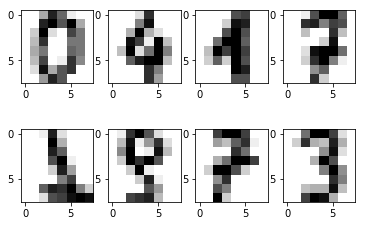

In [4]:
rows_to_display = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
for i in range(8):
        image = data['images'][rows_to_display[i]]
        plt.subplot(2,4,i+1)
        plt.imshow(image, cmap = 'gray_r')
    
    

### K-Nearest Neighbors Model

To begin, we will try training a model using the K-Nearest Neighbors appraoch.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math

threshold = math.floor(data_sub.shape[0]*0.8)
predictors = list(data_sub.columns)
data_sub['target'] = labels
features = data_sub
shuffled = data_sub.sample(frac = 1)
train = shuffled[0:threshold]
test = shuffled[threshold:]

# Train the KNeighborsClassifier Model 
def train(df, k):
    knc = KNeighborsClassifier(n_neighbors = k)
    knc.fit(df[predictors], df['target'])
    return knc
    
def test(knc, df):
    predictions = knc.predict(df[predictors])
    return predictions    

In [6]:
# Takes the DataFrame and performs k-fold validation with the given k value
def cross_validate(df, k):
    # Find the indices for the partitions
    split_length = math.floor(df.shape[0] * 0.25)
    partitions = []
    accuracies = []
    
    # Split the DataFrame into its k partitions
    for i in range(4):
        if i == 3:
            partitions.append(df[split_length*i:])
        else:
            partitions.append(df[split_length*i:split_length*(i+1)])
    
    # Iterate through the DataFrames in the partition list
    for i in range(len(partitions)):
        # Select one as the test set
        test_iter = partitions[i]
        
        # Use the remainder to form the training set
        train_iter = pd.concat((partitions[:i] + partitions[i+1:]))
        
        # Train a KNeighborsClassifier on the training set
        knc_iter = train(train_iter, k)
        
        # Use the test function to calculate the predicted labels
        knc_predict = test(knc_iter, test_iter)
        
        # Calculate the accuracy score and save it into a list
        accuracies.append(accuracy_score(test_iter['target'], knc_predict))
        
        
    # Return the mean of the accuracy scores
    return np.mean(accuracies)

In [7]:
accuracy_dict = {}
for i in range(1,10):
    accuracy_dict[i] = cross_validate(shuffled, i)
    

accuracy_dict

{1: 0.9888666171739668,
 2: 0.986085127443702,
 3: 0.9860863647611977,
 4: 0.9849703043801039,
 5: 0.9855295718881465,
 6: 0.9827456075228904,
 7: 0.9844172234595397,
 8: 0.983304875030933,
 9: 0.9816332590942837}

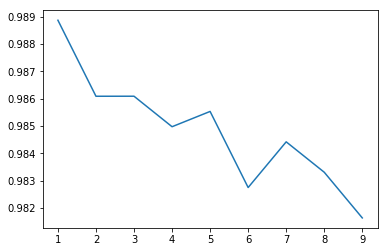

In [8]:
accuracy_series = pd.Series(accuracy_dict)

accuracy_series.plot()
plt.show()

### Neural Network with One Hidden Layer

In [9]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


def train_nn(num_neurons, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = num_neurons, max_iter = 1000)
    mlp.fit(train_features, train_labels)
    return mlp

def test_nn(nn_model, test_features, test_labels):
    predictions = nn_model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(data, num_neurons):
    accuracy = []
    # Use KFold to split the data
    knf = KFold(n_splits = 4, random_state = 2)
    for train_index, test_index in knf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        mlp = train_nn(num_neurons, train_features, train_labels)
        accuracy.append(test_nn(mlp, test_features, test_labels))
        
    mean_accuracy = np.mean(accuracy)
    return accuracy


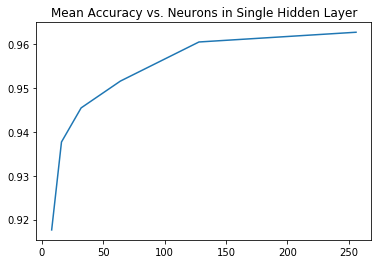

In [10]:
# Select the various number of hidden neuron values we'll be training with
hidden_neurons = [(8,), (16,), (32,),  (64,),  (128,),  (256,)]
mean_accuracy = []

for neurons in hidden_neurons:
    mean_accuracy.append(np.mean(cross_validate(data_sub, neurons)))

plt.figure()
plt.title("Mean Accuracy vs. Neurons in Single Hidden Layer")

x = [i[0] for i in hidden_neurons]
plt.plot(x, mean_accuracy)

### Observations

It seems like adding more neurons to the hidden layer helps to improve accuracy from about 92.5% to 96%. Here we are using simple accuracy as a measure, only checking whether the classification was made correctly, with no consideration for false positives or true negatives. This accuracy is lower than the one seen in the K-Nearest Neighbors model so there isn't much reason to use a single layer network.

### Neural Net with Two Hidden Layers

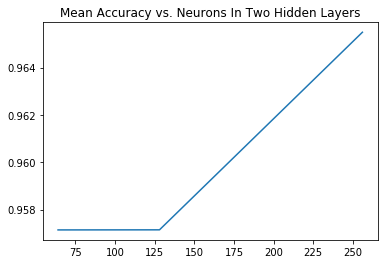

In [11]:
# Attempt to make a neural net with two layers
hidden_neurons = [(64, 64), (128,128), (256,256)]
mean_accuracy_two = []

for neurons in hidden_neurons:
    mean_accuracy_two.append(np.mean(cross_validate(data_sub, neurons)))
    
plt.figure()
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in hidden_neurons]
plt.plot(x, mean_accuracy_two)

Adding a second hidden layer leads to further increases in mean accuracy. This holds true across all three sizes of hidden layers. As a final extension, let's try adding a third hidden layer and see if the trend holds.

### Neural Network with Three Hidden Layers

In [12]:
def cross_validate(data, num_neurons):
    accuracy = []
    # Use KFold to split the data
    knf = KFold(n_splits = 6, random_state = 2)
    for train_index, test_index in knf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        mlp = train_nn(num_neurons, train_features, train_labels)
        accuracy.append(test_nn(mlp, test_features, test_labels))
        
    mean_accuracy = np.mean(accuracy)
    return accuracy

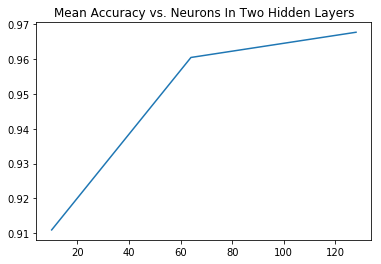

In [13]:
hidden_neurons = [(10,10,10), (64,64,64), (128,128,128)]
mean_accuracy_three = []

for neurons in hidden_neurons:
    mean_accuracy_three.append(np.mean(cross_validate(data_sub, neurons)))
    
plt.figure()
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in hidden_neurons]
plt.plot(x, mean_accuracy_three)

The accuracy of the model continues to increase for the same number of neurons per layer even with 6-fold cross validation. While the accuracy does increase for more complex networks, they will also require more time to train and run. Thus there is a tradeoff to consider between model complexity and performance.

# Conclusion

In this project we looked at different depths of neural networks for classifying images of handwritten digits. We found that increasing network complexity yielded higher accuracy, albeit with diminishing returns.  